# ATSAC Loop Detector Data in AWS Athena

We would like to evaluate the ergonomics and cost-effectiveness of
storing ATSAC loop detector data. The data can get quite large,
with thousands of detectors reporting every thirty seconds.

We have loaded several days of data into AWS Athena
which we will then use in a brief analysis.


## Setup

First, we make some relevant imports:

In [1]:
import altair
import contextily
import geopandas
import matplotlib.pyplot as plt
import pandas
import pyathena
import shapely

I created an AWS profile for the proof-of-concept AWS datalake account named `poc`,
allowing me to connect using the nice PyAthena DBAPI wrapper:

In [2]:
connection = pyathena.connect(
    profile_name="poc",
    work_group="atsac_workgroup",
    region_name="us-west-2",
    schema_name="atsac",
)

## Making a Query

Let's assemble a query for all the detectors that fall within the Arts District/Little Tokyo neighborhood.
We first read in that geometry data from the LA GeoHub, and extract the shape we want:

In [3]:
NEIGHBORHOOD_URL = (
    "https://opendata.arcgis.com/datasets/674f80b8edee4bf48551512896a1821d_0.geojson"
)
neighborhoods = geopandas.read_file(NEIGHBORHOOD_URL)

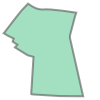

In [4]:
historic_cultural = neighborhoods[neighborhoods.Name == "Historic Cultural"].iloc[0]
historic_cultural

def _to_2d(x, y, z):
    return tuple(filter(None, [x, y]))

shape = shapely.ops.transform(_to_2d, historic_cultural.geometry)
shape

We can now use this shape to make a query to Google BigQuery,
and see how long it takes to run:

In [5]:
%%time

query = f"""
SELECT ID,TIMESTAMP,LAT,LON,VOL FROM atsac
WHERE ST_WITHIN(ST_POINT(LON, LAT), ST_GEOMETRY_FROM_TEXT('{shape.wkt}'))
AND DATE(TIMESTAMP) = DATE('2020-03-31')
"""

df = pandas.read_sql(query, connection)

CPU times: user 18.5 s, sys: 4.84 s, total: 23.4 s
Wall time: 4min 21s


Let's inspect this result:

In [6]:
df

,ID,TIMESTAMP,LAT,LON,VOL
0,3405391182382,2020-03-31 00:00:30,34.053995,-118.238220,0
1,3405391182382,2020-03-31 00:01:00,34.053995,-118.238220,0
2,3405391182382,2020-03-31 00:01:30,34.053995,-118.238220,0
3,3405391182382,2020-03-31 00:02:00,34.053995,-118.238220,0
4,3405391182382,2020-03-31 00:02:30,34.053995,-118.238220,0
...,...,...,...,...,...
460795,3405081182428,2020-03-31 23:57:30,34.050877,-118.242874,0
460796,3405081182428,2020-03-31 23:58:00,34.050877,-118.242874,0
460797,3405081182428,2020-03-31 23:58:30,34.050877,-118.242874,0
460798,3405081182428,2020-03-31 23:59:00,34.050877,-118.242874,0


## Plotting the results

Okay, that's a lot of data, let's get a daily aggregate for each detector,
and visualize the results:

In [7]:
volume = df.groupby("ID").agg({
    "LAT": "first",
    "LON": "first",
    "VOL": "sum",
})
gdf = geopandas.GeoDataFrame(
    volume,
    crs="EPSG:4326",
    geometry=geopandas.points_from_xy(volume.LON, volume.LAT),
).drop(columns=["LAT", "LON"])

<ipython-input-8-8726c733f113>:22: FutureWarning: The "contextily.tile_providers" module is deprecated and will be removed in contextily v1.1. Please use "contextily.providers" instead.
  contextily.add_basemap(ax, url=contextily.sources.ST_TONER_LITE)
<ipython-input-8-8726c733f113>:22: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  contextily.add_basemap(ax, url=contextily.sources.ST_TONER_LITE)


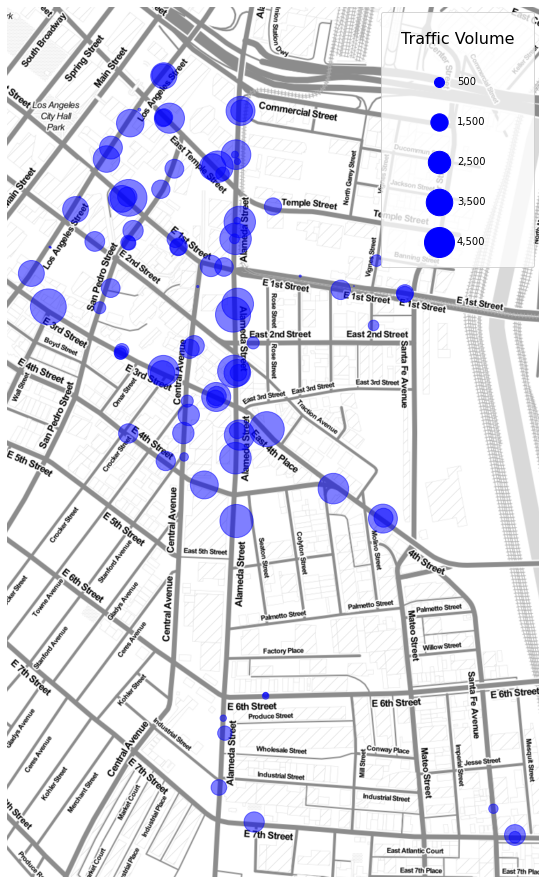

In [8]:
WEB_MERCATOR = 3857
SCALE=5
fig, ax = plt.subplots(figsize=(16,16))
gdf.to_crs(epsg=WEB_MERCATOR).plot(
    alpha=0.5,
    color="blue",
    ax=ax,
    markersize=gdf.VOL/SCALE,
    legend=True,
)
steps = range(100, 1000, 200)
plt.legend(
    [ax.scatter([],[], s=y, color="blue", label=y) for y in steps],
    [f"{y*SCALE:,}" for y in steps],
    labelspacing=3,
    borderpad=2,
    title="Traffic Volume",
    title_fontsize=16,
    fancybox=True,
    loc="upper right",
)
contextily.add_basemap(ax, url=contextily.sources.ST_TONER_LITE)
ax.set_axis_off()

Let's also create a time series chart of the volume for the ten most active detectors:

In [9]:
highest_traffic = gdf.sort_values("VOL", ascending=False).head(10)
tseries = df[df.ID.isin(highest_traffic.index)]
tseries = tseries.groupby(["ID", pandas.Grouper(key="TIMESTAMP", freq="H")]).agg({
    "VOL": "sum",
}).reset_index().rename(columns={
    "ID": "Detector",
    "TIMESTAMP": "Time",
    "VOL": "Volume",
})

# Localize timezone
tseries = tseries.assign(Time=tseries.Time.dt.tz_localize("US/Pacific"))

In [10]:
altair.Chart(tseries).mark_line().encode(
    x="Time:T",
    y="Volume:Q",
    color="Detector:N",
)

alt.Chart(...)

## Assembling a more complex query

Now let's ask more complex question of the data. Specifically, what are the loop detectors that
receive the most traffic overnight? We can filter the table by the hours in
a typical graveyard shift, and aggregate them by detector id as such:

In [11]:
%%time

query = """
SELECT ARBITRARY(LAT) AS latitude, ARBITRARY(LON) AS longitude, SUM(VOL) AS volume
FROM atsac
WHERE (EXTRACT(hour FROM TIMESTAMP) > 10) OR (EXTRACT(hour FROM TIMESTAMP) < 6)
GROUP BY ID
"""

df = pandas.read_sql(query, connection)

CPU times: user 469 ms, sys: 46.9 ms, total: 516 ms
Wall time: 29.1 s


In [12]:
df

,latitude,longitude,volume
0,34.025713,-118.240071,3000
1,34.039852,-118.340739,27675
2,34.053477,-118.291649,39337
3,34.013603,-118.417813,12504
4,34.037656,-118.307641,58642
...,...,...,...
18378,34.194764,-118.457492,28044
18379,34.270139,-118.431142,33002
18380,34.221617,-118.423243,62625
18381,34.226863,-118.411861,134


Okay! Now we have the aggregated detector data for all the detectors citywide
between the hours of 10 PM and 6 AM. Let's visualize the five hundred detectors
with the most activity during the graveyard shift:

In [13]:
gdf = geopandas.GeoDataFrame(
    df,
    crs="EPSG:4326",
    geometry=geopandas.points_from_xy(df.longitude, df.latitude),
).drop(columns=["latitude", "longitude"])

<ipython-input-14-87cf8062bc07>:9: FutureWarning: The "contextily.tile_providers" module is deprecated and will be removed in contextily v1.1. Please use "contextily.providers" instead.
  contextily.add_basemap(ax, url=contextily.sources.ST_TONER_LITE)
<ipython-input-14-87cf8062bc07>:9: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  contextily.add_basemap(ax, url=contextily.sources.ST_TONER_LITE)


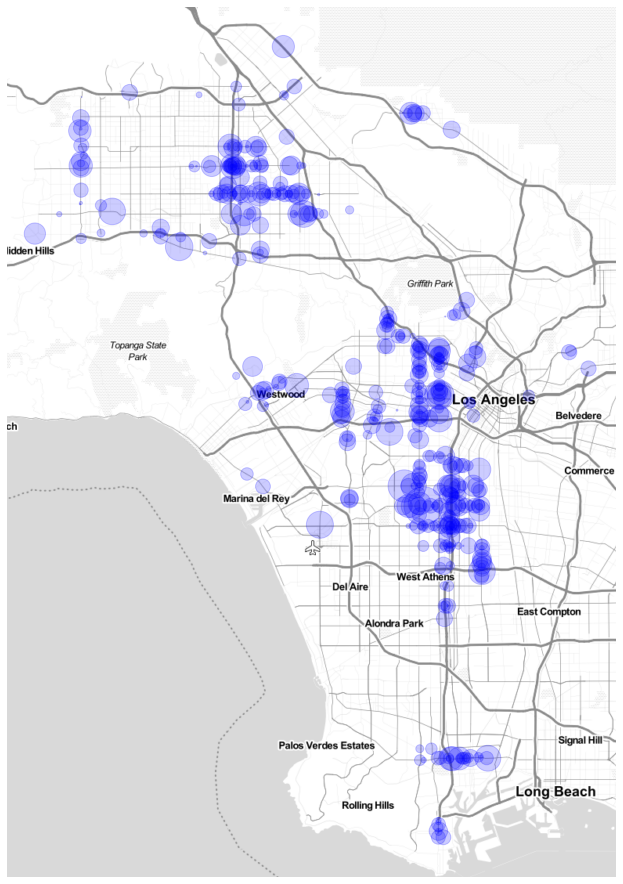

In [14]:
fig, ax = plt.subplots(figsize=(16,16))
gdf.sort_values("volume", ascending=False).head(500).to_crs(epsg=WEB_MERCATOR).plot(
    alpha=0.2,
    color="blue",
    ax=ax,
    markersize=gdf.volume/100.,
    legend=True,
)
contextily.add_basemap(ax, url=contextily.sources.ST_TONER_LITE)
ax.set_axis_off()